In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from nltk.stem import WordNetLemmatizer


# EASY

In [2]:
df_start = pd.read_csv('../data/singapore_airlines_reviews.csv')
df_start.head()

,published_date,published_platform,rating,type,text,title,helpful_votes
0,2024-03-12T14:41:14-04:00,Desktop,3,review,We used this airline to go from Singapore to L...,Ok,0
1,2024-03-11T19:39:13-04:00,Desktop,5,review,The service on Singapore Airlines Suites Class...,The service in Suites Class makes one feel lik...,0
2,2024-03-11T12:20:23-04:00,Desktop,1,review,"Booked, paid and received email confirmation f...",Don’t give them your money,0
3,2024-03-11T07:12:27-04:00,Desktop,5,review,"Best airline in the world, seats, food, servic...",Best Airline in the World,0
4,2024-03-10T05:34:18-04:00,Desktop,2,review,Premium Economy Seating on Singapore Airlines ...,Premium Economy Seating on Singapore Airlines ...,0


Узнаем какие типы отзывов вообще бывают:

review


<Axes: >

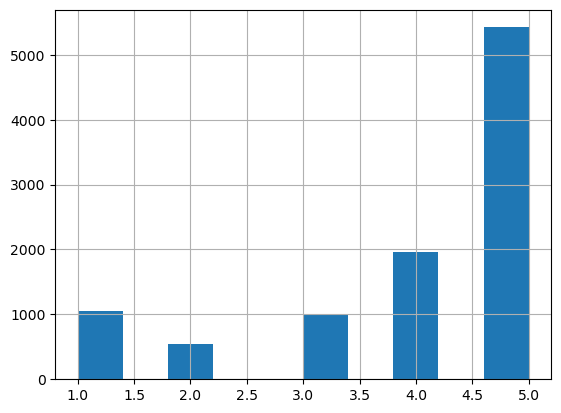

In [3]:
print(*df_start['type'].unique())
df_start['rating'].hist()

Мы видим дисбаланс классов, поэтому будем использовать метрику `f1_score` Давайте объединим титульник и текст в нашей модели, т.к. хотим преобразовать наш датасет в BOW (и порядок слов нам будет неважен).

Чтобы упростить задачу, оставим только текст отзыва и сам рейтинг

In [4]:
df = df_start[['rating']].copy()
df['text'] = (df_start[["title"]].squeeze() + " " + df_start[["text"]].squeeze())
df.head()

,rating,text
0,3,Ok We used this airline to go from Singapore t...
1,5,The service in Suites Class makes one feel lik...
2,1,"Don’t give them your money Booked, paid and re..."
3,5,Best Airline in the World Best airline in the ...
4,2,Premium Economy Seating on Singapore Airlines ...


Перед нами классическая задача классификации. Хотим угадать рейтинг от 1 до 5. Давайте преобразуем наши данные удалив пунктуацию и приводя к нижнему регистру

In [5]:
from nltk.stem.porter import *


def preprocess_text(text):
    text = str(text)
    text = re.sub(r"[^\w\s]", " ", text.lower()).split()
    return " ".join(text)


df['preprocessed_text'] = df['text'].apply(preprocess_text)
df.head()

,rating,text,preprocessed_text
0,3,Ok We used this airline to go from Singapore t...,ok we used this airline to go from singapore t...
1,5,The service in Suites Class makes one feel lik...,the service in suites class makes one feel lik...
2,1,"Don’t give them your money Booked, paid and re...",don t give them your money booked paid and rec...
3,5,Best Airline in the World Best airline in the ...,best airline in the world best airline in the ...
4,2,Premium Economy Seating on Singapore Airlines ...,premium economy seating on singapore airlines ...


In [6]:
x_test, x_train, y_test, y_train = train_test_split(df['preprocessed_text'], df['rating'], train_size=0.8)

bow = CountVectorizer()
x_test = bow.fit_transform(x_test).toarray()
x_train = bow.transform(x_train).toarray()
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((2000, 18008), (8000, 18008), (2000,), (8000,))

In [7]:
model = LogisticRegression()
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
f1_score(y_test, y_pred, average='micro')

/home/gabik/anaconda3/envs/hse_ml_course_2024/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.641625

Как можно заметить, модель работает возможно не так, как нам бы хотелось. 
Давайте попробуем исправить это

# Normal 

In [8]:
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /home/gabik/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/gabik/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/gabik/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Давайте попробуем добавить стемминг и будем удалять стоп-слова, которые достали выше

In [9]:
stemmer = PorterStemmer()


def preprocess_text(text):
    text = str(text)
    text = re.sub(r"[^\w\s]", " ", text.lower()).split()
    text = " ".join([stemmer.stem(word) for word in text if word not in stop_words])
    return text


df = df_start[['rating']].copy()
df['preprocessed_text'] = (df_start[["title"]].squeeze() + " " + df_start[["text"]].squeeze()).apply(preprocess_text)
df['raw_text'] = (df_start[["title"]].squeeze() + " " + df_start[["text"]].squeeze())
df.head()

,rating,preprocessed_text,raw_text
0,3,ok use airlin go singapor london heathrow issu...,Ok We used this airline to go from Singapore t...
1,5,servic suit class make one feel like vip servi...,The service in Suites Class makes one feel lik...
2,1,give money book paid receiv email confirm extr...,"Don’t give them your money Booked, paid and re..."
3,5,best airlin world best airlin world seat food ...,Best Airline in the World Best airline in the ...
4,2,premium economi seat singapor airlin worth mon...,Premium Economy Seating on Singapore Airlines ...


Убедившись, что стоп-слава действительно удалены и текст обработан как мы хотим, посмотрим как теперь будет работать наша модель

In [10]:
x_test, x_train, y_test, y_train = train_test_split(df['preprocessed_text'], df['rating'], train_size=0.8)

x_train.shape, x_test.shape, y_train.shape, y_test.shape

((2000,), (8000,), (2000,), (8000,))

In [11]:
fit_results = []

# Перебираем модели и векторизацию
models = {"LogisticRegression": LogisticRegression(),
          "RandomForestClassifier": RandomForestClassifier(),
          "SVC(kernel='linear')": SVC(kernel='linear'),
          "SVC(kernel='poly')": SVC(kernel='poly'),
          "SVC(kernel='rbf')": SVC(kernel='rbf')}

# Перебираем модели и векторизацию
for vect in [CountVectorizer(), TfidfVectorizer()]:
    for name, model in models.items():
        pipeline = Pipeline(
            [
                ("vect", vect),
                ("model", model),
            ]
        )
        pipeline.fit(x_train, y_train)
        y_pred = pipeline.predict(x_test)
        metric = f1_score(y_test, y_pred, average='micro')
        fit_results.append(
            {
                'vect': vect.__class__.__name__,
                'model': name,
                'f1': metric,
            }
        )

fit_results = pd.DataFrame(fit_results).sort_values('f1', ascending=False)
fit_results

/home/gabik/anaconda3/envs/hse_ml_course_2024/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,vect,model,f1
7,TfidfVectorizer,SVC(kernel='linear'),0.660875
5,TfidfVectorizer,LogisticRegression,0.641375
0,CountVectorizer,LogisticRegression,0.634750
9,TfidfVectorizer,SVC(kernel='rbf'),0.609250
1,CountVectorizer,RandomForestClassifier,0.605875
4,CountVectorizer,SVC(kernel='rbf'),0.603125
6,TfidfVectorizer,RandomForestClassifier,0.602500
2,CountVectorizer,SVC(kernel='linear'),0.600625
3,CountVectorizer,SVC(kernel='poly'),0.551250
8,TfidfVectorizer,SVC(kernel='poly'),0.539625


После наших изменений исходная модель стала работать даже чуточку хуже :)

Но все же SVC показала нам невероятные результаты, так что давайте посмотрим как будет работать наша лучшая модель на своем примере

In [12]:
model = SVC(kernel='linear')
bow = TfidfVectorizer()
bow_result_train = bow.fit_transform(x_train)

model.fit(bow_result_train, y_train)

SVC(kernel='linear')

In [13]:
good_review = "Gorgeous I used the airline to fly from Russia to America. The children were delighted! We were fed very tasty and even danced at the request of my husband"
bad_review = "The worst flight in my life. The children seemed to be screaming from all sides. My brand-new apple noise-canceling headphones didn't save me."
reviews = pd.Series([preprocess_text(good_review), preprocess_text(bad_review)])
transformed = bow.transform(reviews).toarray()
model.predict(transformed)

array([5, 1])

Получили правильные оценки, за что SVC получает плюсик в карму